In [1]:
import torch

# HiFi-VC

In this seminar we will try to implement [HiFi-VC](https://arxiv.org/abs/2203.16937) model for Any-to-Any Voice Conversion and discuss how to reproduce a badly reproducible paper. 

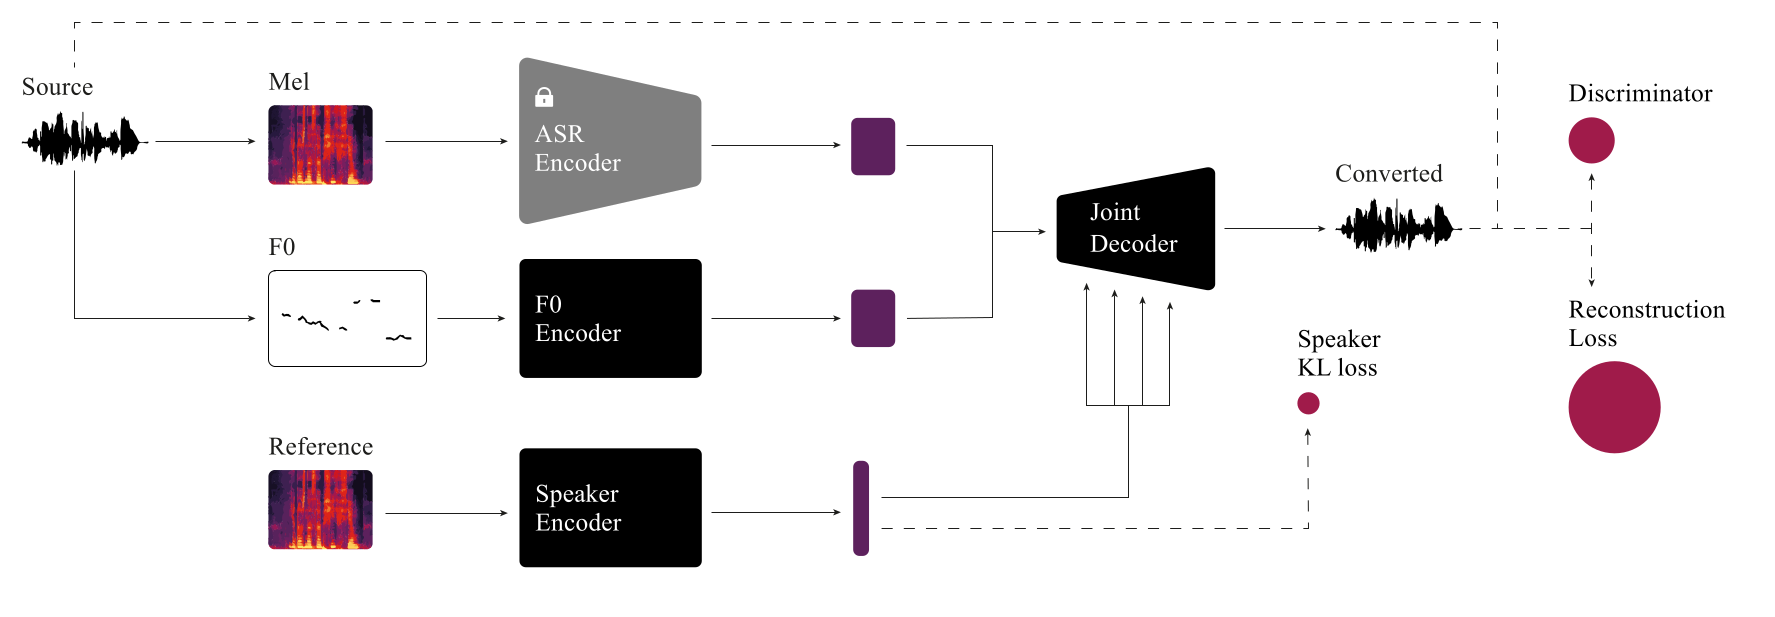

Authors did not provide code for their model. We can only access inference script and final model saved in TorchScript. Even thought it is worse than the full code, we can still restore some missing details.

## Torch.jit, TorchScript

TorchScript is a way to create serializable and optimizable models from PyTorch code. Any TorchScript program can be saved from a Python process and loaded in a process where there is no Python dependency (for example, in C++ code).

How does it work? Recall that PyTorch create flow of operations on the fly:

<img alt="How autograd works" src="https://github.com/pytorch/pytorch/raw/main/docs/source/_static/img/dynamic_graph.gif">

TorchScript allows to capture model definition and its data flow. For this, it provides several tools. 

In [2]:
# tracing
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.linear = torch.nn.Linear(4, 4)

    def forward(self, x, h):
        new_h = torch.tanh(self.linear(x) + h)
        return new_h, new_h

my_cell = MyCell()
x, h = torch.rand(3, 4), torch.rand(3, 4)
print('Torch Version result:')
print(my_cell(x, h))
# torch.jit -- module for TorchScript
traced_cell = torch.jit.trace(my_cell, (x, h)) # pass inputs to *trace* operations
print('--------------')
print('TorchScript Captured Syntax')
print(traced_cell)
print('--------------')
print('TorchScript Version result:')
traced_cell(x, h)

Torch Version result:
(tensor([[ 0.5660,  0.7014,  0.2030, -0.6052],
        [ 0.6397,  0.8071,  0.6561, -0.2450],
        [ 0.6290,  0.8544,  0.6861, -0.5514]], grad_fn=<TanhBackward0>), tensor([[ 0.5660,  0.7014,  0.2030, -0.6052],
        [ 0.6397,  0.8071,  0.6561, -0.2450],
        [ 0.6290,  0.8544,  0.6861, -0.5514]], grad_fn=<TanhBackward0>))
--------------
TorchScript Captured Syntax
MyCell(
  original_name=MyCell
  (linear): Linear(original_name=Linear)
)
--------------
TorchScript Version result:


(tensor([[ 0.5660,  0.7014,  0.2030, -0.6052],
         [ 0.6397,  0.8071,  0.6561, -0.2450],
         [ 0.6290,  0.8544,  0.6861, -0.5514]], grad_fn=<TanhBackward0>),
 tensor([[ 0.5660,  0.7014,  0.2030, -0.6052],
         [ 0.6397,  0.8071,  0.6561, -0.2450],
         [ 0.6290,  0.8544,  0.6861, -0.5514]], grad_fn=<TanhBackward0>))

What exactly has this done? It has invoked the Module, recorded the operations that occurred when the Module was run, and created an instance of `torch.jit.ScriptModule` (of which `TracedModule` is an instance).

Intermidiate representations are stored in `graph` object. It has a very low-level look:

In [3]:
traced_cell.graph

graph(%self.1 : __torch__.MyCell,
      %x : Float(3, 4, strides=[4, 1], requires_grad=0, device=cpu),
      %h : Float(3, 4, strides=[4, 1], requires_grad=0, device=cpu)):
  %linear : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="linear"](%self.1)
  %20 : Tensor = prim::CallMethod[name="forward"](%linear, %x)
  %11 : int = prim::Constant[value=1]() # /tmp/ipykernel_5430/2117610899.py:8:0
  %12 : Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu) = aten::add(%20, %h, %11) # /tmp/ipykernel_5430/2117610899.py:8:0
  %13 : Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu) = aten::tanh(%12) # /tmp/ipykernel_5430/2117610899.py:8:0
  %14 : (Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu), Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu)) = prim::TupleConstruct(%13, %13)
  return (%14)

In [4]:
# Python Higher-Lever version of graph
print(traced_cell.code)

def forward(self,
    x: Tensor,
    h: Tensor) -> Tuple[Tensor, Tensor]:
  linear = self.linear
  _0 = torch.tanh(torch.add((linear).forward(x, ), h))
  return (_0, _0)



So why did we do all this? There are several reasons:

1. TorchScript code can be invoked in its own interpreter, which is basically a restricted Python interpreter. This interpreter does not acquire the Global Interpreter Lock, and so many requests can be processed on the same instance simultaneously.

2. This format allows us to save the whole model to disk and load it into another environment, such as in a server written in a language other than Python

3. TorchScript gives us a representation in which we can do compiler optimizations on the code to provide more efficient execution

4. TorchScript allows us to interface with many backend/device runtimes that require a broader view of the program than individual operators.

In [5]:
class MyDecisionGate(torch.nn.Module):
    def forward(self, x):
        if x.sum() > 0:
            return x
        else:
            return -x

class MyCell(torch.nn.Module):
    def __init__(self, dg):
        super(MyCell, self).__init__()
        self.dg = dg
        self.linear = torch.nn.Linear(4, 4)

    def forward(self, x, h):
        new_h = torch.tanh(self.dg(self.linear(x)) + h)
        return new_h, new_h

my_cell = MyCell(MyDecisionGate())
traced_cell = torch.jit.trace(my_cell, (x, h))

print(traced_cell.dg.code)
print(traced_cell.code)

def forward(self,
    argument_1: Tensor) -> NoneType:
  return None

def forward(self,
    x: Tensor,
    h: Tensor) -> Tuple[Tensor, Tensor]:
  dg = self.dg
  linear = self.linear
  _0 = (linear).forward(x, )
  _1 = (dg).forward(_0, )
  _2 = torch.tanh(torch.add(_0, h))
  return (_2, _2)



/tmp/ipykernel_5430/4234398751.py:3: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.sum() > 0:


**IF Statement is missing**. Tracing runs the code with given input and captures operations. The branches, where we have not beem, are **lost**.

To avoid this, we need a better analyzer: `torch.jit.script`.

In [6]:
scripted_gate = torch.jit.script(MyDecisionGate())

my_cell = MyCell(scripted_gate)
scripted_cell = torch.jit.script(my_cell)

print(scripted_gate.code)
print(scripted_cell.code)

def forward(self,
    x: Tensor) -> Tensor:
  if bool(torch.gt(torch.sum(x), 0)):
    _0 = x
  else:
    _0 = torch.neg(x)
  return _0

def forward(self,
    x: Tensor,
    h: Tensor) -> Tuple[Tensor, Tensor]:
  dg = self.dg
  linear = self.linear
  _0 = torch.add((dg).forward((linear).forward(x, ), ), h)
  new_h = torch.tanh(_0)
  return (new_h, new_h)



We can mix `trace` and `script` together if we do not need or do not want to capture some situations\constants\etc.

In [7]:
class MyRNNLoop(torch.nn.Module):
    def __init__(self):
        super(MyRNNLoop, self).__init__()
        self.cell = torch.jit.trace(MyCell(scripted_gate), (x, h))

    def forward(self, xs):
        h, y = torch.zeros(3, 4), torch.zeros(3, 4)
        for i in range(xs.size(0)):
            y, h = self.cell(xs[i], h)
        return y, h

rnn_loop = torch.jit.script(MyRNNLoop())
print(rnn_loop.code)

def forward(self,
    xs: Tensor) -> Tuple[Tensor, Tensor]:
  h = torch.zeros([3, 4])
  y = torch.zeros([3, 4])
  y0 = y
  h0 = h
  for i in range(torch.size(xs, 0)):
    cell = self.cell
    _0 = (cell).forward(torch.select(xs, 0, i), h0, )
    y1, h1, = _0
    y0, h0 = y1, h1
  return (y0, h0)



Or tracing after script:

In [8]:
class WrapRNN(torch.nn.Module):
    def __init__(self):
        super(WrapRNN, self).__init__()
        self.loop = torch.jit.script(MyRNNLoop())

    def forward(self, xs):
        y, h = self.loop(xs)
        return torch.relu(y)

traced = torch.jit.trace(WrapRNN(), (torch.rand(10, 3, 4)))
print(traced.code)

def forward(self,
    xs: Tensor) -> Tensor:
  loop = self.loop
  _0, y, = (loop).forward(xs, )
  return torch.relu(y)



In [9]:
torch.jit.save(traced, 'traced.pt')

In [10]:
loaded_traced = torch.jit.load('traced.pt')

In [11]:
print(loaded_traced.code)

def forward(self,
    xs: Tensor) -> Tensor:
  loop = self.loop
  _0, y, = (loop).forward(xs, )
  return torch.relu(y)



[Further reading and how to load TorchScript in C++](https://pytorch.org/tutorials/advanced/cpp_export.html)

## HiFi-VC reconstruction

In [12]:
import os
from pathlib import Path
cwd = os.getcwd()
model_path = Path(cwd).parent / 'model.pt'

In [13]:
model = torch.jit.load(model_path, map_location='cpu')

In [1]:
#Let's see what's inside
#model

We can run the model, however, we cannot reverse it to native PyTorch. We need to do some backward engineering to restore original class structure

In [2]:
#Looks very scary
#model.graph

In [3]:
#Better but still hard
#print(model.code)

We will combine knowledge from the paper and `.graph`,`.code`,`._parameters` variables of TorchScript to gain knowledge about original model architecture

### ASR

It is pretty simple, we have a direct link in the paper and we know that it uses bottleneck features $\Rightarrow$ outpurs of Conformer Encoder.

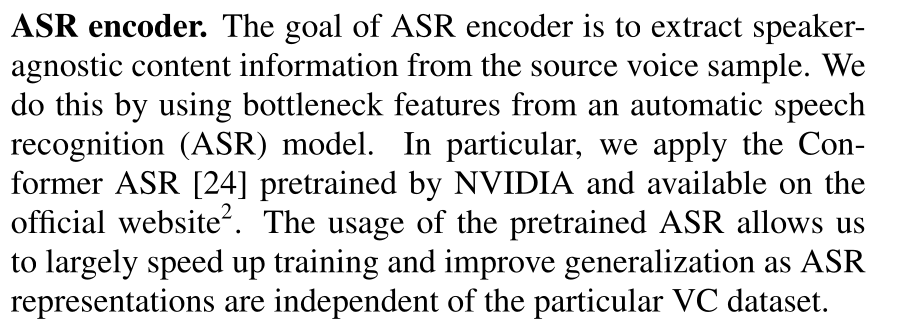

Let's see how to add it to code (turn to Project)

### VAE

With VAE things are harder. There are tons of different variations of VAE and authors informations is not sufficient.

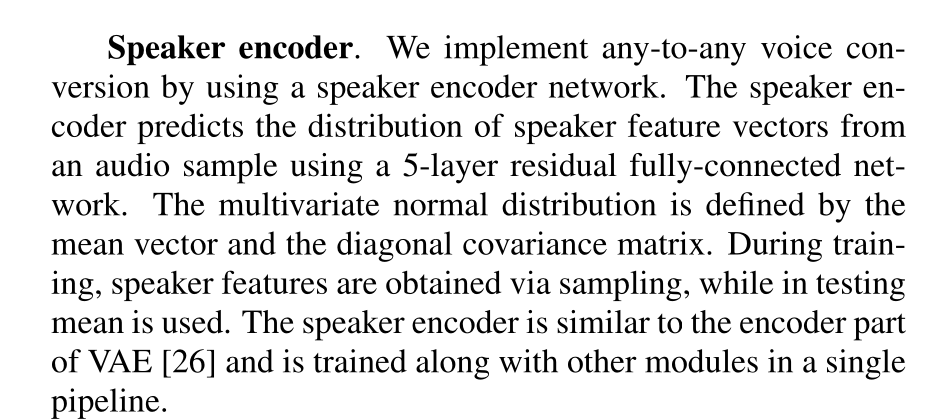

However, we have `.graph`, `.code`, and `.parameters` and can restore original structure!!!

In [17]:
vae = model._voice_conversion.speaker_encoder

In [18]:
vae

RecursiveScriptModule(
  original_name=SpeakerEncoder
  (pre_conv): RecursiveScriptModule(original_name=Conv1d)
  (convs): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=DownBlockSpeaker
      (activation): RecursiveScriptModule(original_name=LeakyReLU)
      (conv_skip): RecursiveScriptModule(original_name=Conv1d)
      (first_conv): RecursiveScriptModule(original_name=Conv1d)
      (second_conv): RecursiveScriptModule(original_name=Conv1d)
    )
    (1): RecursiveScriptModule(
      original_name=DownBlockSpeaker
      (activation): RecursiveScriptModule(original_name=LeakyReLU)
      (conv_skip): RecursiveScriptModule(original_name=Conv1d)
      (first_conv): RecursiveScriptModule(original_name=Conv1d)
      (second_conv): RecursiveScriptModule(original_name=Conv1d)
    )
    (2): RecursiveScriptModule(
      original_name=DownBlockSpeaker
      (activation): RecursiveScriptModule(original_name=LeakyReLU)
      (conv_skip): Re

In [34]:
vae.mean_conv.forward(torch.randn((1, 512, 4))) # note that sometimes forward does not work

RuntimeError: forward() is missing value for argument 'weight'. Declaration: forward(__torch__.torch.nn.modules.conv.___torch_mangle_1728.Conv1d self, Tensor argument_1, Tensor weight) -> (Tensor)

Now we know the modules, but what are the Conv parameters, how does the DownBlockSpeaker works?

For the Conv (or any other `nn` module) parameters, we can see them by accessing `._parameters` OrderedDict. Let's see an example for `mean_conv`.

In [19]:
mean_conv = vae.mean_conv
mean_conv

RecursiveScriptModule(original_name=Conv1d)

In [20]:
mean_conv._parameters['bias'].shape

torch.Size([128])

In [21]:
mean_conv._parameters['weight_v'].shape #note that we have `v` in weight => they used Weight Normalization

torch.Size([128, 512, 1])

In [22]:
conv = torch.nn.Conv1d(512, 128, 1)
conv.weight.shape

torch.Size([128, 512, 1])

Thus, authors used `Conv1d(512, 128, 1)` for mean_conv. Unfortunetly, getting stride or padding is not as easy. We will try to guess them by passing tensor and look at the output.

In [23]:
# Pre_conv
vae.pre_conv._parameters['weight'].shape # no weight norm

torch.Size([32, 80, 3])

In [24]:
# DownSampleBlock
getattr(vae.convs, "0")

RecursiveScriptModule(
  original_name=DownBlockSpeaker
  (activation): RecursiveScriptModule(original_name=LeakyReLU)
  (conv_skip): RecursiveScriptModule(original_name=Conv1d)
  (first_conv): RecursiveScriptModule(original_name=Conv1d)
  (second_conv): RecursiveScriptModule(original_name=Conv1d)
)

In [25]:
getattr(vae.convs, "0").activation(torch.tensor([-1.0])) # -1 to get slope constant

tensor([-0.1000])

In [26]:
getattr(vae.convs, "0").conv_skip._parameters['weight_v'].shape

torch.Size([64, 32, 1])

In [27]:
getattr(vae.convs, "0").first_conv._parameters['weight_v'].shape

torch.Size([32, 32, 3])

In [28]:
getattr(vae.convs, "0").second_conv._parameters['weight_v'].shape

torch.Size([64, 32, 1])

In [40]:
downblock = getattr(vae.convs, "4")
input_ = torch.randn((2, 512, 128))
downblock(input_).shape # -> we have stride 2 in one of the convs?

torch.Size([2, 512, 64])

In [41]:
downblock

RecursiveScriptModule(
  original_name=DownBlockSpeaker
  (activation): RecursiveScriptModule(original_name=LeakyReLU)
  (first_conv): RecursiveScriptModule(original_name=Conv1d)
  (second_conv): RecursiveScriptModule(original_name=Conv1d)
)

<details>
  <summary>Click to expand!</summary>
  
  **Do not be fooled! There is no stride -- look on the graph**
</details>

In [42]:
downblock.graph

graph(%self.1 : __torch__.voice_conversion.modeling.modules.___torch_mangle_1726.DownBlockSpeaker,
      %argument_1.1 : Tensor):
  %63 : int = prim::Constant[value=1]()
  %31 : bool = prim::Constant[value=1]()
  %30 : bool = prim::Constant[value=0]()
  %25 : int = prim::Constant[value=2]() # /mnt/data1/home/ext.akashkin/repos/voice_conversion/src/voice_conversion/modeling/modules.py:176:0
  %28 : int = prim::Constant[value=0]() # /mnt/data1/home/ext.akashkin/repos/voice_conversion/src/voice_conversion/modeling/modules.py:176:0
  %second_conv.1 : __torch__.torch.nn.modules.conv.___torch_mangle_1725.Conv1d = prim::GetAttr[name="second_conv"](%self.1)
  %second_conv.3 : __torch__.torch.nn.modules.conv.___torch_mangle_1725.Conv1d = prim::GetAttr[name="second_conv"](%self.1)
  %weight_g.1 : Tensor = prim::GetAttr[name="weight_g"](%second_conv.3)
  %second_conv.5 : __torch__.torch.nn.modules.conv.___torch_mangle_1725.Conv1d = prim::GetAttr[name="second_conv"](%self.1)
  %weight_v.1 : Tensor

In [43]:
print(downblock.code)

def forward(self,
    argument_1: Tensor) -> Tensor:
  second_conv = self.second_conv
  second_conv0 = self.second_conv
  weight_g = second_conv0.weight_g
  second_conv1 = self.second_conv
  weight_v = second_conv1.weight_v
  first_conv = self.first_conv
  first_conv0 = self.first_conv
  weight_g0 = first_conv0.weight_g
  first_conv1 = self.first_conv
  weight_v0 = first_conv1.weight_v
  activation = self.activation
  x_skip = torch.avg_pool1d(argument_1, [2], [2], [0])
  _0 = (activation).forward(argument_1, )
  weight = torch._weight_norm(weight_v0, weight_g0)
  input = torch.avg_pool1d((first_conv).forward(_0, weight, ), [2], [2], [0])
  _1 = (activation).forward1(input, )
  weight0 = torch._weight_norm(weight_v, weight_g)
  _2 = torch.add(x_skip, (second_conv).forward(_1, weight0, ))
  return _2



### F0 Encoder

We can similarly find the F0 encoder, but we won't do this as authors ablation says that F0 does not add much quality.

### Speaker Projection

Okay, we have the following:

```
In particular, ASR  bottleneck and F0 features are directly served as generator input. Speaker embeddings are linearly projected to match the dimensions of HiFi-GAN upsampling blocks and then added to their inputs.
```

And the picture:
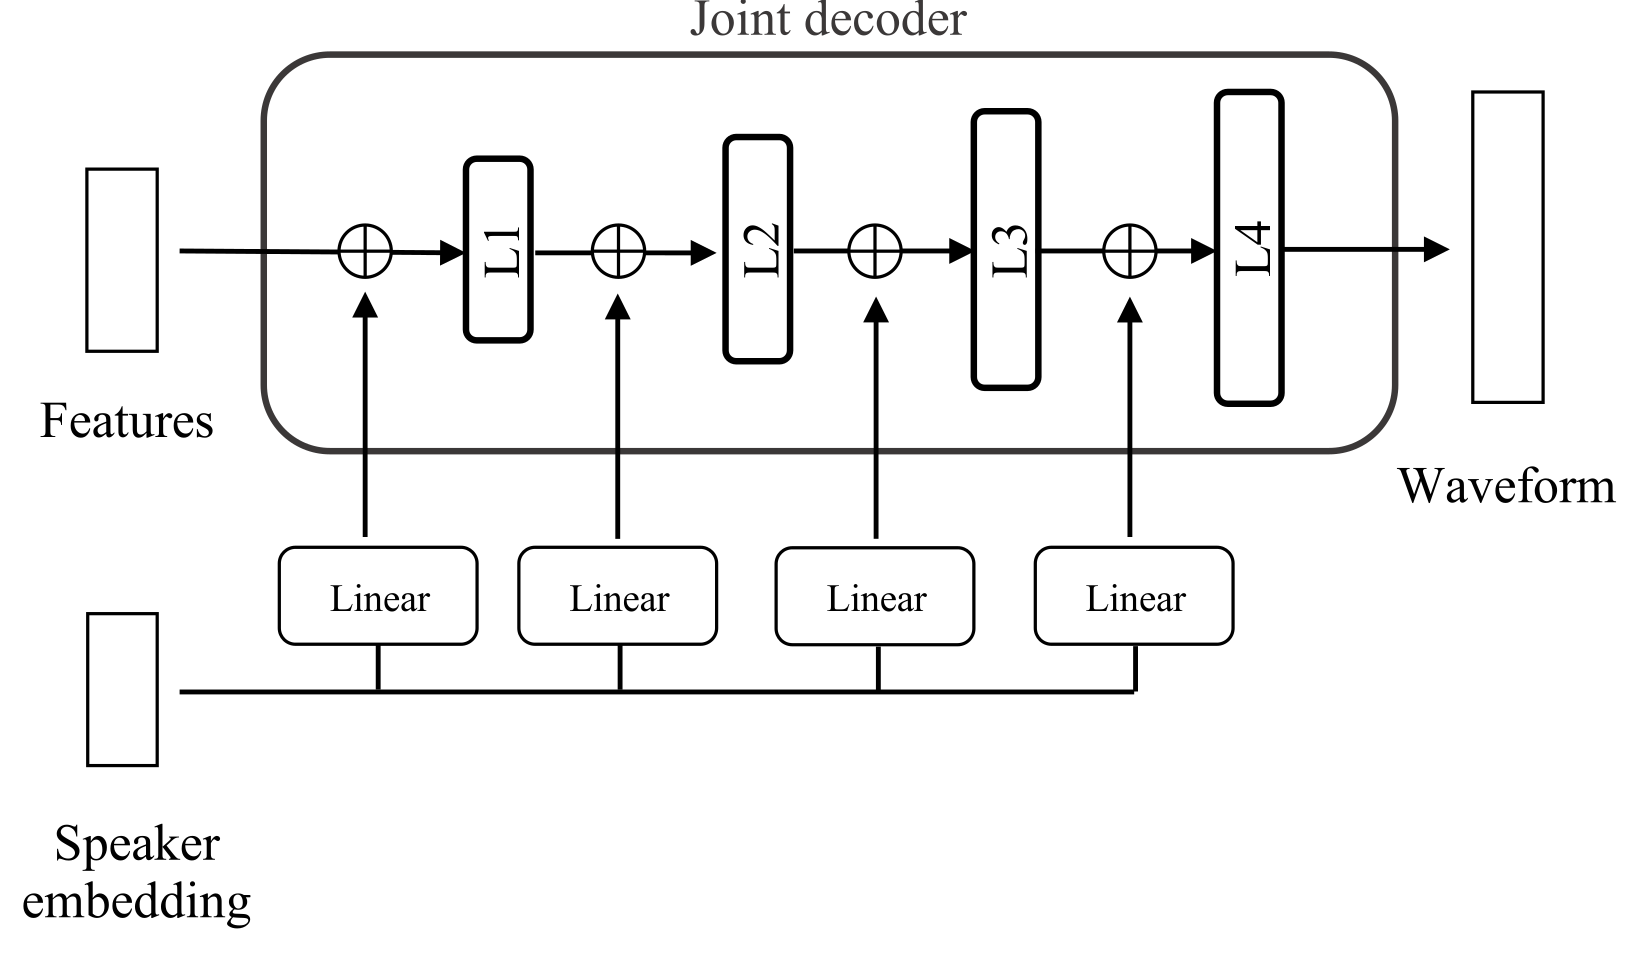

Hence HiFi-GAN part of HiFi-VC (the generator) looks like this:

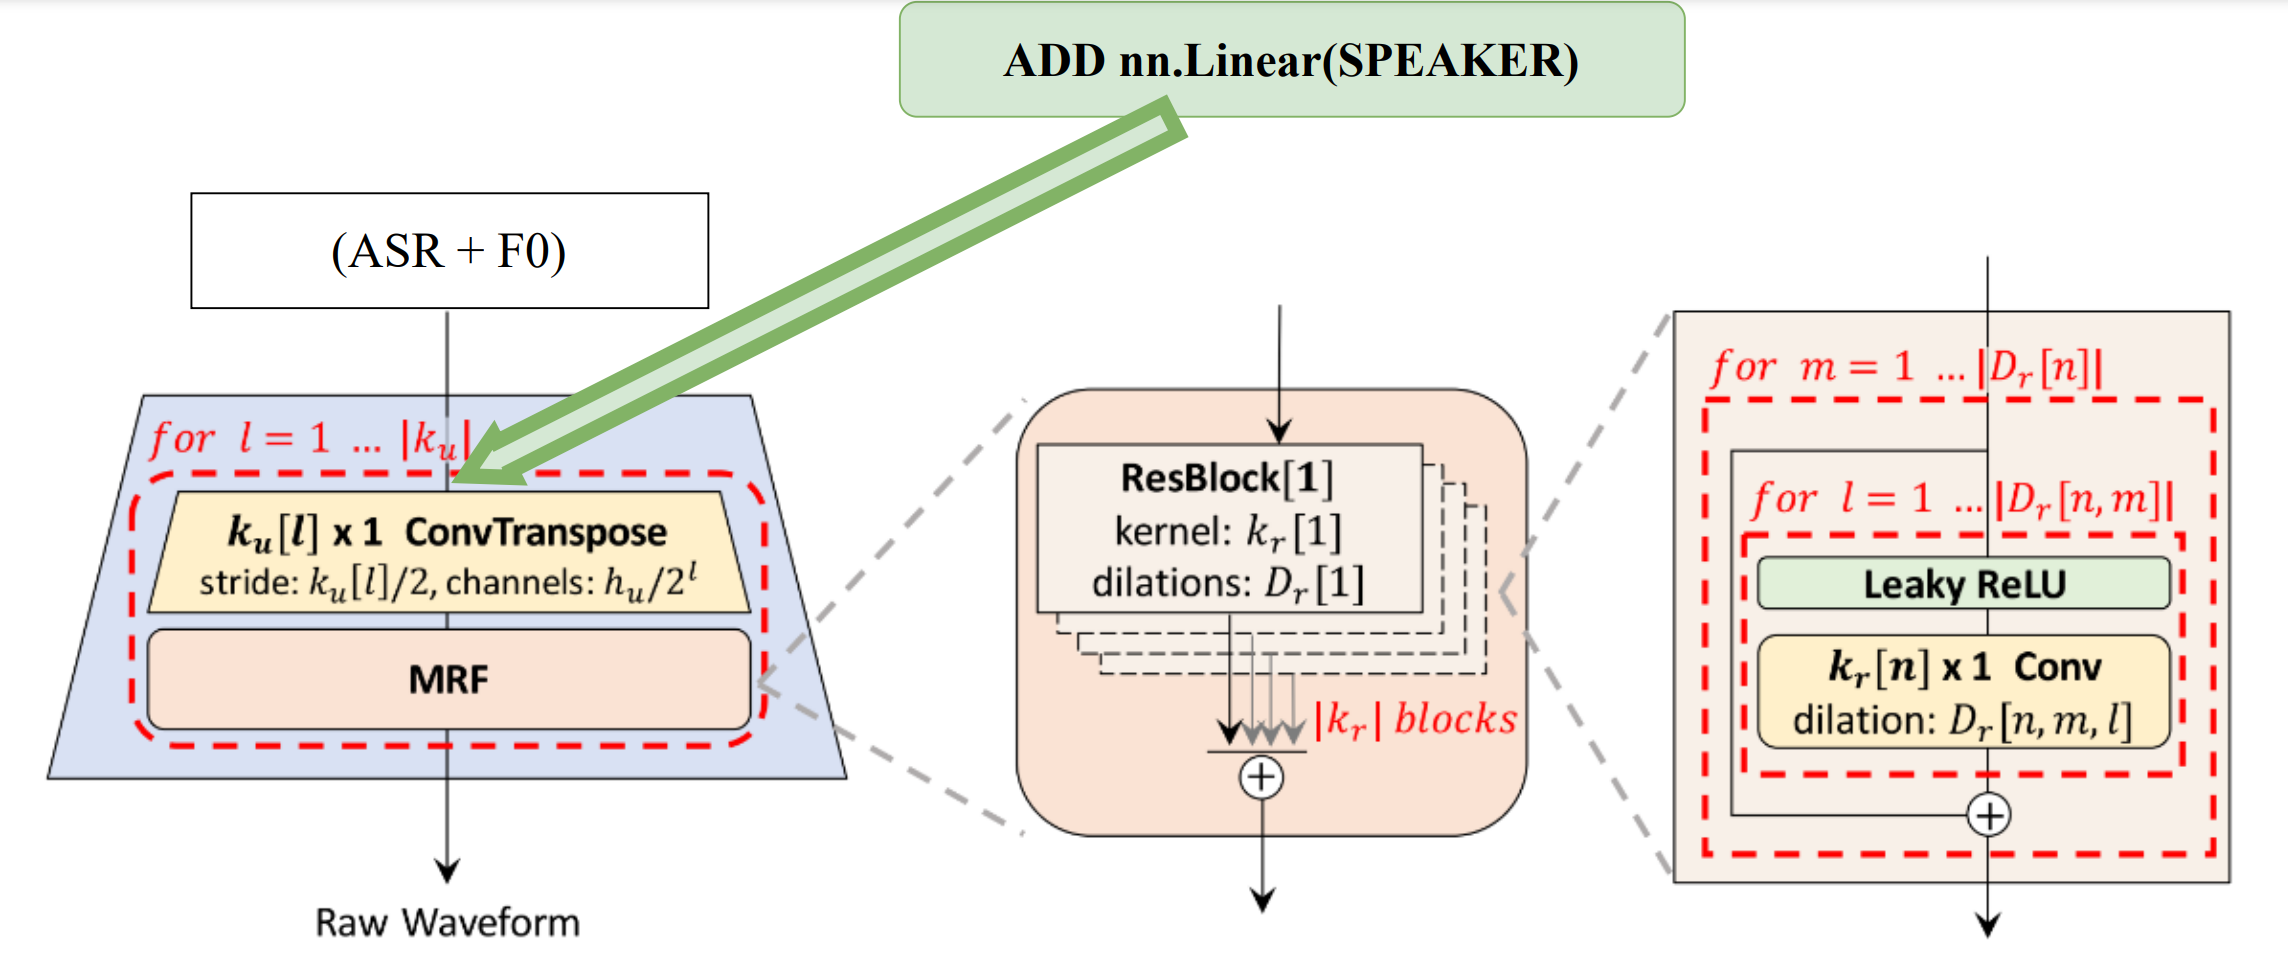

<details>
  <summary>Click to expand!</summary>
  
  **NO**. 
  
  ![stickeg.png](sticker.png)
  
  
  If we look on the graph, we will se that the projection is done in another way:
  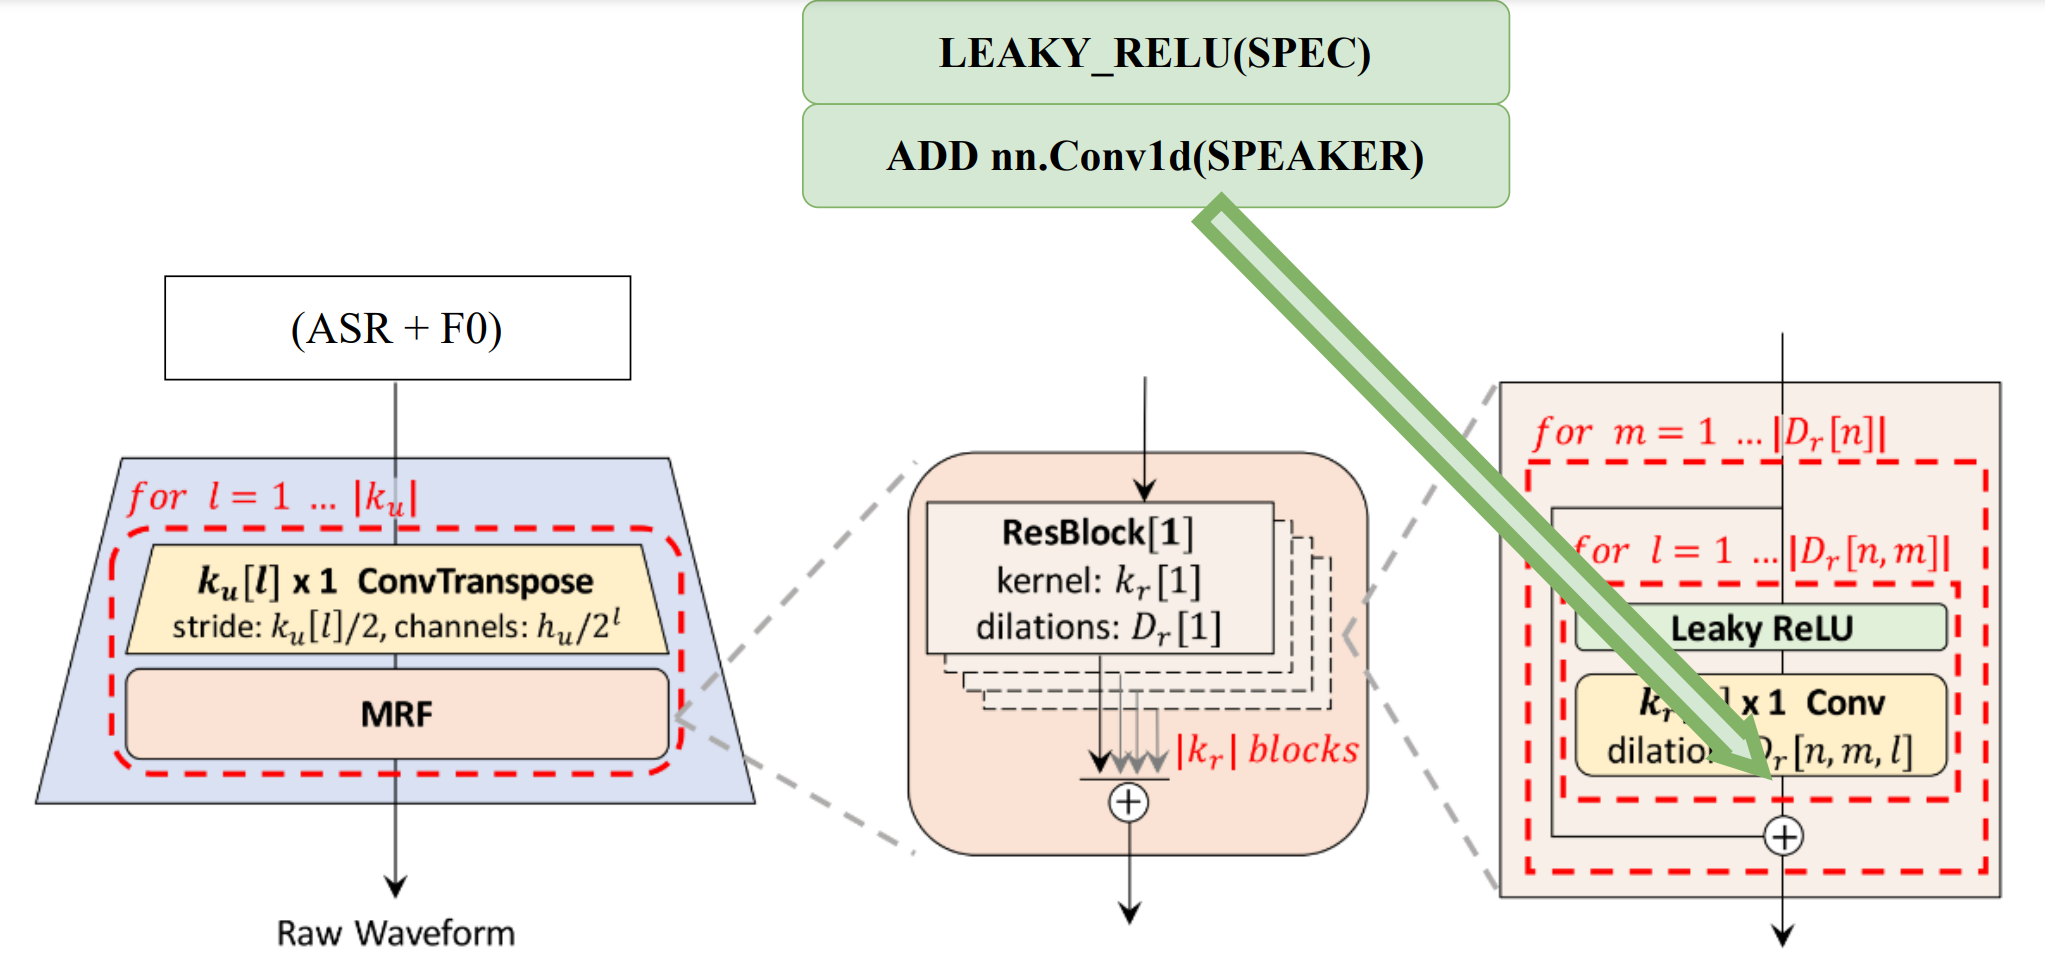
</details>

<details>
  <summary>Click to expand!</summary>
  
  Moreover, we have more than an sum of ASR and F0:

  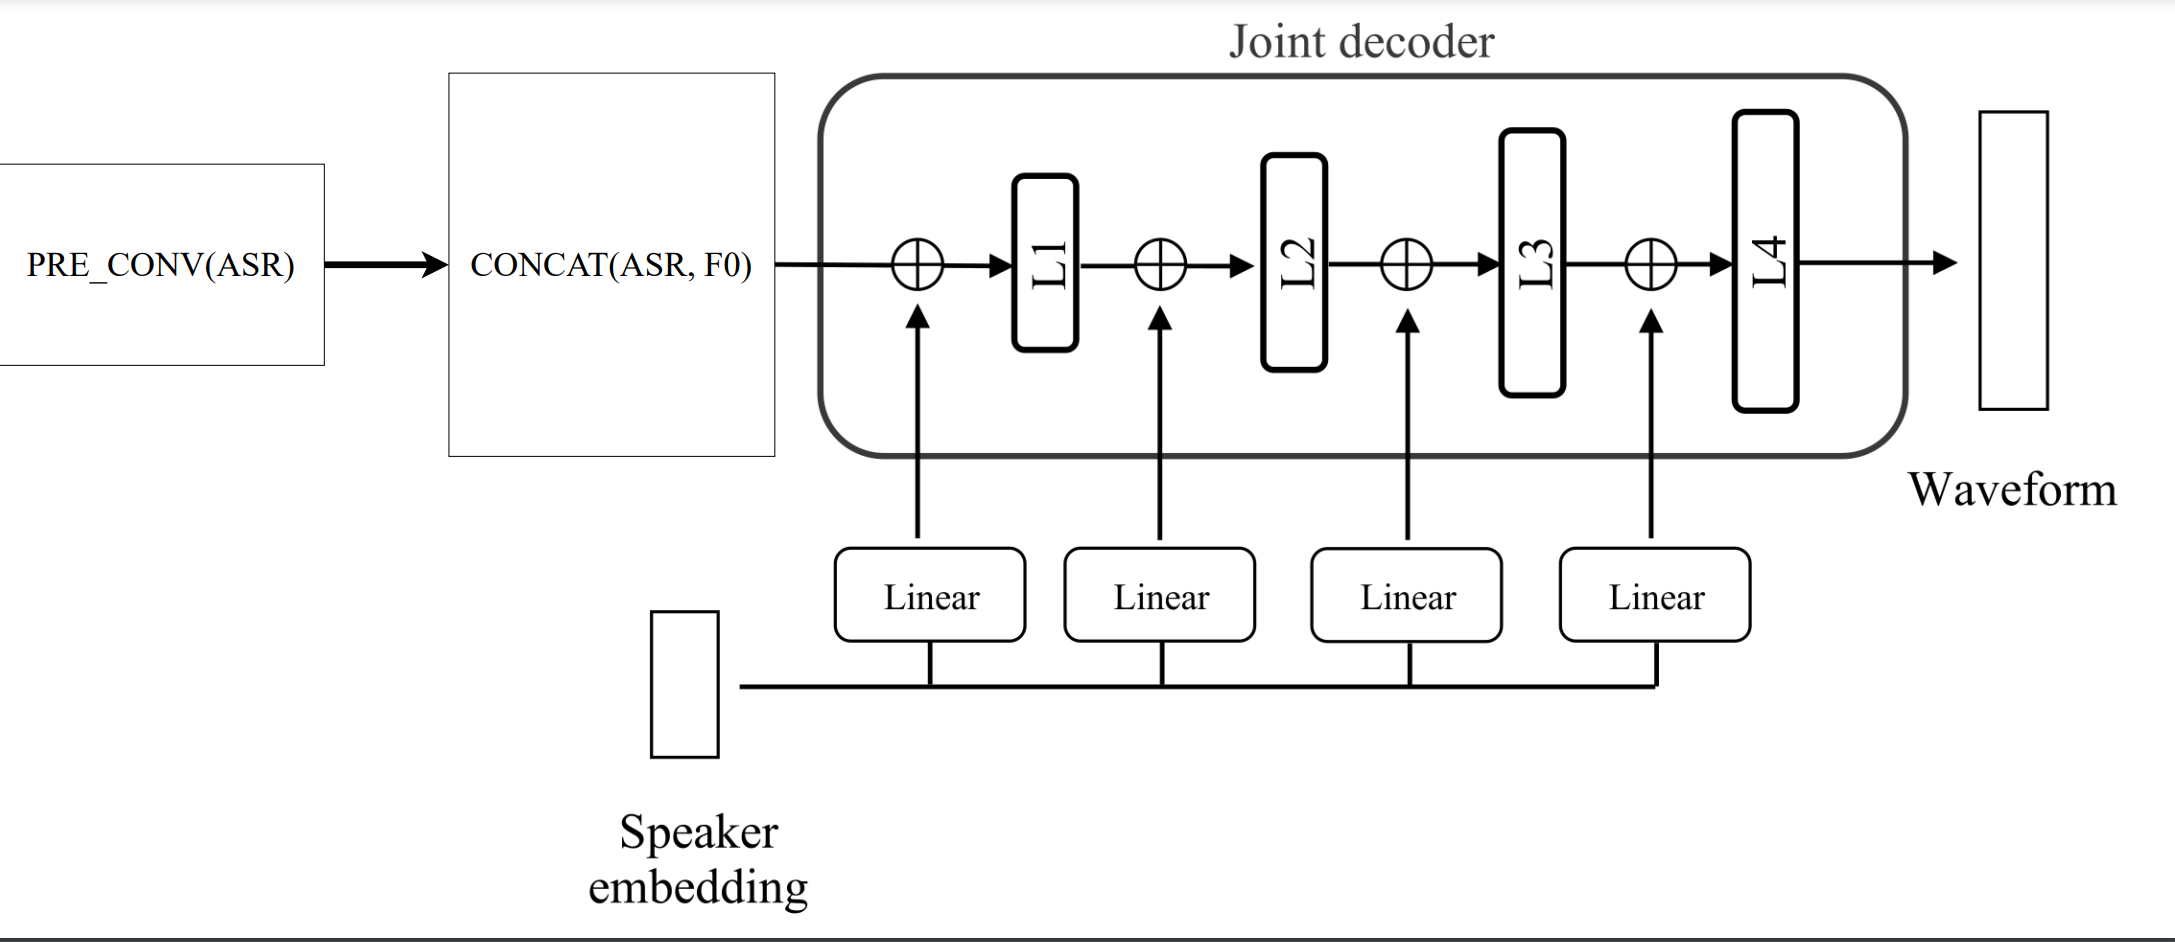
</details>